# X-ray spectroscopies

Tuning the photon energy to the X-ray regime, processes involving the transition of core electrons can be probed, providing measurements which are very sensitive to elements and local environment [norman18, bergmann17, bookhaven]. Here we will discuss the modeling of four such spectroscopies, as illustrated in {numref}`xray-processes`:


```{figure} ../img/xray/processes.svg
---
name: xray-processes
---
Electronic processes involved in the X-ray sectroscopies discussed in this tutorial.
```

- In [X-ray photoemission spectroscopy (XPS)](#x-ray-photoemission-spectroscopy) the photoionization of the molecular system is probed, yielding insight into *occupied states*.

- In [X-ray absorption spectroscopy (XAS)](#x-ray-absorption-spectroscopy) the transition of core electrons to occupied or continuum states is probed, providing information on *unoccupied states* or the *local chemical environment*.

- In [X-ray emission spectroscopy (XES)](#x-ray-emission-spectroscopy) the fluorescent decay of higher-lying electrons into a previously prepared core-hole is measured, yielding information on *occupied states*.

- In [resonant inelastic X-ray scattering (RIXS)](#resonant-inelastic-x-ray-scattering) (also termed resonant X-ray emission spectroscopy, or resonant X-ray Raman spectroscopy), the core-excitation and subsequent fluorescent decay is measured, yielding information on both *occupied and unoccupied states*, including the ability of probing *(local) vibrational modes*.

The element-specificity of these techniques arise from the significant differences in the energy of core orbital energies (and thus in excitation/fluorescence energies), as illustrated in {numref}`edges_elements`:

```{figure} ../img/xray/edges_elements.svg
---
name: edges_elements
---
Linear attenuation coefficient for the noble gases and carbon to neon. Data extracted from [NIST](https://www.nist.gov/pml/x-ray-form-factor-attenuation-and-scattering-tables).
```

Here the linear attenuation coefficient for four noble gases (left), and carbon to neon (right) are shown, with the former including labels for the origin of each set of edge/set of features (using the Siegbahn notation with $n=1,2,3,...$ labeled $K, L, M, ...$). We see that there are significant energy differences between the various absorption features, which then enables us to focus on particular elements and edges by tuning photon energies.

Modeling these processes are complicated by a number of factors, such as:

- Strong [relaxation effects](#relaxation), arising from the significant change in shielding of the nuclear charge arising from the creation/annihilation of a core-hole.

- Potentially significant impact from [relativity](#relativity), with the strong potential experienced by the core electrons yielding large shifts due to (scalar) relativistic effects. In addition, spin-orbit coupling split degeneracies in, e.g., $2p$ (the $L_{2,3}$-edge), necessitating at least an approximate inclusion of such effects for these edges.

- Core-excitation and -ionization processes are [embedded in a continumm of valence-ionized states](#decoupling-from-valence-continuum), making the application of, e.g., a standard Davidson approach for resolving eigenstates unsuitable.

- For higher photon energies the contribution of *multipole-allowed* states enables transitions which are electric-dipole forbidden.

- Computational chemistry more often is concerned with valence properties, meaning that standard [basis sets](#basis-set-considerations) (among others) are tailored for core-transition processes.

- For DFT method there are substantial influences due to the [self-interaction error](#self-interaction-error-in-dft), which are strong due to the compact nature of core orbitals.

This tutorial will now discuss the calculation of these X-ray spectra, focusing on how this is achieved using TDDFT and ADC. Following illustrations of how the processes can be modeled, basic analysis schemes and some the issues raised above will be considered in some detail.

```{note}
*Could* split the notebook into several smaller notebooks (*e.g.* 'calculate', 'analysis', 'special topics', 'large systems', 'recommendations')
```

In [4]:
# loading modules and defining broadening functions

# standard Python modules and functions
from scipy.interpolate import interp1d
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import copy

# QC software suites and functionalities
from pyscf import gto, scf, mp, cc
import veloxchem as vlx
import gator
import adcc
from veloxchem.rsplinabscross import LinearAbsorptionCrossSection

# for vlx
silent_ostream = vlx.OutputStream(None)
from mpi4py import MPI
comm = MPI.COMM_WORLD

# au to eV conversion factor
au2ev = 27.211386

# broadening functions, called with
#         (energies, intensities, start energy, end energy, energy step, broadening)
def lorentzian(x, y, xmin, xmax, xstep, gamma):
    xi = np.arange(xmin,xmax,xstep); yi=np.zeros(len(xi))
    for i in range(len(xi)):
        for k in range(len(x)): yi[i] = yi[i] + y[k] * (gamma/2.) / ( (xi[i]-x[k])**2 + (gamma/2.)**2 )
    return xi,yi

def gaussian(x, y, xmin, xmax, xstep, sigma):
    xi = np.arange(xmin,xmax,xstep); yi=np.zeros(len(xi))
    for i in range(len(xi)):
        for k in range(len(y)):
            yi[i] = yi[i] + y[k]*np.e**(-((xi[i]-x[k])**2)/(2*sigma**2))
    return xi,yi

## X-ray photoemission spectroscopy

In XPS the photoemission of electrons is measured, yielding information on core-electron binding energies. Here we focus on the calculation of ionization potentials (IP:s), from which the isotropic photoemission spectrum is formed by giving each IP the same intensity and then broadening with a function. Can go beyond that using Dyson orbitals, but it typically doesn't make much of a difference [refs: Dyson, difference]. For more details on the modeling of these processes with ADC and TDDFT, good starting points include [XPS with ADC/TDDFT].

### IP:s from Koopmans' theorem

A simple model for estimating ionization potentials and electron affinities is from Koopmans' theorem, where it is calculated from the MO energies. For water, we obtain a 1s IP estimate of:

In [5]:
water = """
O       0.0000000000     0.0000000000     0.1178336003
H      -0.7595754146    -0.0000000000    -0.4713344012
H       0.7595754146     0.0000000000    -0.4713344012
"""

# SCF calculation
molecule = vlx.Molecule.read_str(water, units='angstrom')
basis    = vlx.MolecularBasis.read(molecule, "6-31G")
scf_drv  = vlx.ScfRestrictedDriver(comm,ostream=silent_ostream)
scf_drv.compute(molecule, basis)

# Extract orbital energies
orbital_energies = scf_drv.scf_tensors['E']
print('1s IP from the Koopmans theorem:',np.around(au2ev*orbital_energies[0],2))

1s IP from the Koopmans theorem: -559.5


This can be compared to the experimental value, which is 539.9 eV. The overestimation of almost 20 eV is due to lack of [relaxation](relaxation), which results from the reorganization of the valence electrons in response to a reduction in screening of the nuclei. By comparison, in valence spectroscopies the change in shielding is significantly smaller, yielding a far smaller error due to the lack of relaxation for, e.g., calculation of HOMO IP:s or LUMO EA:s.

An approach for including relaxation effects IP calculations is to instead use the $\Delta\textrm{SCF}$ approach, in which the difference in total energy between the neutral and a core-hole system yields estimates of core-electron binding energies.

### The maximum overlap method (MOM)

```{note}
Improve this section.
```

In order to do this, a core-hole state need to be converged, as can be done using a number of methods including...[refs] We will here focus on the use of the maximum overlap method (MOM) [refs], using which a wave function optimization is restricted to contain the maximum overlap to the previous electronic structure. This is done by considering the  eigenvalue equation

\begin{equation}
\textbf{FC}^{\textrm{new}} = 
\textbf{SC}^{\textrm{new}} \epsilon
\end{equation}

We then chose to overlap the most with the span

\begin{equation}
\textbf{O} = 
\left( \textbf{C} \right)^{\dagger} \textbf{SC}^{\textrm{new}}
\end{equation}

A core-hole wave function can then be converged by:

1. Calculating the wave function of the system lacking a core-hole.

2. Use above wave function as a starting guess for a new wave function optimization, removing an electron from desired core orbital.

3. Optimizing this state using the MOM restriction.

This can then converge many unstable states, including core-ionized states and some core-excited states. Some care should observed, though:

- If excited states are considered, check that the final state is reasonable.

- Systems with delocalized core orbitals need to be localized, for example by employing ECP:s [refs].

- If post-HF methods are used, the ground state calculation can attempt to (partially) fill the core-hole, leading to a corrupt wave function which represents some intermediate between a core-hole/valence-hole state [refs].

```{note}
We currently use `pyscf` for the calculations involving explicit core-holes, as VeloxChem lacks MOM (for now).
```

### IP:s from $\Delta\textrm{SCF}$

The IP of water using $\Delta\textrm{SCF}$ is calculated ass:

In [6]:
# Build mol-object and perform ground state SCF with pyscf
mol       = gto.Mole()
mol.atom  = water
mol.basis = '6-31G'
mol.build()

scf_res = scf.UHF(mol)
scf_res.kernel()

# Copy wave function information and change occupancy of alpha1 to 0 (i.e. prepare the core-hole)
mo0  = copy.deepcopy(scf_res.mo_coeff)
occ0 = copy.deepcopy(scf_res.mo_occ)
occ0[0][0] = 0.0

# Perform wave function calculation with the MOM restriction
scf_ion = scf.UHF(mol)
scf.addons.mom_occ(scf_ion, mo0, occ0)
scf_ion.kernel()

# Resulting IP from energy difference
print('Ionization potential:',np.around(au2ev*(scf_ion.energy_tot() - scf_res.energy_tot()),2),'eV')

converged SCF energy = -75.9838703827192  <S^2> = 6.3389294e-12  2S+1 = 1


Overwritten attributes  get_occ  of <class 'pyscf.scf.uhf.UHF'>


converged SCF energy = -56.0754789470864  <S^2> = 0.76257805  2S+1 = 2.0125387
Ionization potential: 541.73 eV


This estimate is within 2 eV from experiment, and we can include electron correlation using MP2:

In [5]:
# Run MP2 on neutral and core-hole wave functions
mp_res = mp.MP2(scf_res).run()
mp_ion = mp.MP2(scf_ion).run()

# IP from energy difference
print('Ionization potential:',np.around(au2ev*(mp_ion.e_tot - mp_res.e_tot),2),'eV')

E(UMP2) = -76.1130483955489  E_corr = -0.129178012829713
E(UMP2) = -56.1523709631034  E_corr = -0.0768920160169649
Ionization potential: 543.16 eV


And we can also use KS-DFT:

In [255]:
# SCF calculation with unrestricted KS-DFT
dft_res    = scf.UKS(mol)
dft_res.xc = 'b3lyp'
dft_res.kernel()

# Prepare core-hole
mo0  = copy.deepcopy(dft_res.mo_coeff)
occ0 = copy.deepcopy(dft_res.mo_occ)
occ0[0][0] = 0.0

# SCF with core-hole
dft_ion = scf.UKS(mol); dft_ion.xc = 'b3lyp'
scf.addons.mom_occ(dft_ion, mo0, occ0)
dft_ion.kernel()

# IP from energy difference
print('Ionization potential:',np.around(au2ev*(dft_ion.energy_tot() - dft_res.energy_tot()),2),'eV')

converged SCF energy = -76.3649949864645  <S^2> = 3.0730973e-13  2S+1 = 1
converged SCF energy = -56.5317122508954  <S^2> = 0.75629843  2S+1 = 2.0062885
Ionization potential: 539.69 eV


MP2 and DFT currently brings us **away** from experiment, but we note that the basis set is small and ill suited for core properties. Using a cc-pCVTZ basis we obtain:
- HF: 538.93 eV
- MP2: 540.26 eV
- B3LYP: 539.19 eV

*i.e.* closer to experiment for the correlated methods (note that scalar-relativistic effects will shift these results upwards by $\sim$0.37 eV).

### Spectra from $\Delta\textrm{SCF}$

The X-ray photoemission spectrum can be formed by calculating all relavant core-electron binding energies (IP:s), give each unique ionization equal intensity, and broaden over the result with a lorentzian or gaussian convolution formula. The choice of broadening depends on the dominant broadening effect (lifetime of excited/ionized state, experimental resolution, *etc*), but we will here focus on pure lorentzian broadening.

We here consider ethyl trifluoroacetate( (CF$_3$-CO-O-CH$_2$-CH$_3$), also known as the ['ESCA' molecule](https://doi.org/10.1016/j.elspec.2012.05.009), which possess very illustrative shifts in XPS features (IP:s) of the carbon $K$-edge due to interactions with the very electronegative oxygen and fluorine atoms. We calculate the four carbon 1s IP:s with $\Delta\textrm{SCF}$:

In [7]:
esca   = '''
C         1.1183780041   -0.3449927563    0.0140172822
C         0.2599020293    0.9430366372   -0.0248385056
F         2.4019839124   -0.0408200726   -0.0368443870
F         0.8399255955   -1.1560630574   -1.0169777359
F         0.8945563482   -1.0267696528    1.1485539196
O         0.7954196415    2.0187110930    0.0011424145
O        -1.0675509573    0.8144007049   -0.0614767265
C        -1.7486063992   -0.4602333713   -0.1739210991
C        -3.1986940727   -0.1850294900    0.1302033614
H        -1.3268717284   -1.1720377773    0.5289059043
H        -1.6185520565   -0.8344576449   -1.1859838788
H        -3.3116641442    0.1959612359    1.1419001202
H        -3.7716619472   -1.1057672384    0.0380096706
H        -3.6012985602    0.5468300237   -0.5651778685            
'''

# Create mol object and perform neutral SCF calculation
mol_esca = gto.Mole()
mol_esca.atom  = esca; mol_esca.basis = 'STO-3G'
mol_esca.build()
scf_esca = scf.UHF(mol_esca)
scf_esca.kernel()

# Perform core-hole calculation for each carbon atom (MOs 5-8) and append SCF IPs to a list
esca_ips = []
for i_mo in [5,6,7,8]:
    mo0 = copy.deepcopy(scf_esca.mo_coeff)
    occ0 = copy.deepcopy(scf_esca.mo_occ)
    occ0[0][i_mo] = 0.0
    ion_tmp = scf.UHF(mol_esca)
    scf.addons.mom_occ(ion_tmp, mo0, occ0)
    ion_tmp.kernel()
    esca_ips.append(au2ev*(ion_tmp.energy_tot() - scf_esca.energy_tot()))

converged SCF energy = -594.320690263589  <S^2> = 1.6621939e-08  2S+1 = 1
converged SCF energy = -583.365537674046  <S^2> = 0.76705671  2S+1 = 2.0169846
SCF not converged.
SCF energy = -583.447978368628 after 50 cycles  <S^2> = 0.76807021  2S+1 = 2.0179893
converged SCF energy = -583.561134582533  <S^2> = 0.76454928  2S+1 = 2.0144967
converged SCF energy = -583.615548638303  <S^2> = 0.75826809  2S+1 = 2.0082511


```{note}
There are some convergence issues for the above calculation, largely relating to the minimal basis set used. These issues disappear for more flexible basis set.
```

The spectrum is formed by giving each IP equal weight and broadening with a lorentzian and a gaussian, for which FWHM $= \gamma $ and FWHM $ 2\sqrt{2\ln{2}} \sigma$, respectively.

NameError: name 'esca_ips' is not defined

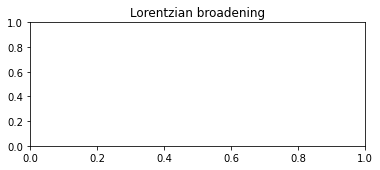

In [7]:
plt.figure(figsize=(6,5))
# Broadening with a lorentzian, with FWHM = 0.4 eV
plt.subplot(211); plt.title('Lorentzian broadening')
x,y = esca_ips,np.ones((len(esca_ips)))
xi,yi = lorentzian(x,y,min(x)-2,max(x)+2,0.01,0.4); plt.plot(xi,yi*0.4)
# Broadening with a gaussian, with FWHM = 0.4 eV
plt.subplot(212); plt.title('Gaussian broadening')
xi,yi = gaussian(x,y,min(x)-2,max(x)+2,0.01,0.4/(2*np.sqrt(2*np.log(2)))); plt.plot(xi,yi)
plt.tight_layout(); plt.show()

For the comparison to [experiment](https://doi.org/10.1016/j.elspec.2012.05.009) a cc-pVTZ basis set is selected, augmented with additional core-polarizing functions for the carbon atoms (i.e. cc-pCVTZ):


```{figure} ../img/xray/esca_xps.svg
---
name: esca_xps
---
Carbon 1s XPS of ESCA, comparing $\Delta\textrm{SCF}$ results to experiment. Theoretical spectrum shifted by 0.11 eV (to account for relativistic effects) and broadened by 0.3 eV.
```

The features originate in, from low to high energy: -CH$_3$, -CH$_2$-, -CO-, and CF$_3$. We note a good agreement for the first two features, but the comparison deteriorates for higher energies. This is largely an effect of the more significant change in electronic structure imposed by the very electronegative fluorine and oxygen atoms, which the current level of theory is not capable of describing as well as the other features.

### Other approaches

Brief discussion - IP-ADC, IP-CCSD, ...


## X-ray absorption spectroscopy

In XAS the energy-dependent photoabsorption of the sample is measured, probing excitation of core electrons to bound or continuum states. These two different final states then provide information on unoccupied states and local chemical environment, espectively, with a prototypical spectrum of a conjugated system: 


```{figure} ../img/xray/xafs.svg
---
name: xafs
---
Prototypical X-ray absorption spectrum of a conjugated system.
```

Above the spectrum we see the distinction of the various spectrum regions, consisting of:

- **NEXAFS (near-edge X-ray absorption fine structure:** the region in which transitions to bound states is probed (this region is also known as XANES, X-ray absorption near-edge structure).

- **EXAFS (extended X-ray absorption fine structure):** which consists of transitions to continuum states, which is modulated by constructive or destructive interference between the emitted electron and the environment. This thus provide information on local chemical bonds.

- **XAFS (X-ray absorption fine structure):** spanning both regions.

For the remainder of this tutorial we will focus on NEXAFS, with more details for modeling this process found in [wenzel, besley, fransson]. Discussions on modeling EXAFS can be found, e.g., in [exafs].

Included in {numref}`xafs` is also the position of the IP, above which the oscillatory pattern due to interference with the environment is initiated, and assignment of typical features ($\pi^*$, Rydberg, and $\sigma^*$). Transitions to $\pi^*$ states are typically low in energy and very intense, and thus easy to identify. Rydberg states are typically weak and converge to the ionization potential. Finally, transitions to $\sigma^*$ states can be found above the ionization potential.

### Decoupling transitions from the valence continuum

A complication that arise when considering core excitations is the embedding of the core-excited states into the continuum of valence-ionized states. A number of approaches have been developed to remove this issue, including:

- The core-valence separation (CVS) approximation [schirmer, wenzel, coriani]

- Restricted energy window, which share some common ideas with CVS [rew-tddft]

- Using the complex polarization propagator (CPP), where the response at arbitrary frequencies is directly probed [norman]

- Real-time propagation of the electronic structure [rt-methods]

- Methods which construct explicit excited states [refs]

The focus in this tutorial is the use of the CVS approximation and the CPP approach, with which interior eigenstates/response at arbitrary frequencies can be directly address:


```{figure} ../img/xray/cvs_adc.svg
---
name: cvs_adc
---
Global spectrum of water, using the 6-311G basis set. Results obtained with ADC(1), CVS-ADC(1), ADC(2), CVS-ADC(2), and CPP-DFT. CPP-DFT results obtained using the B3LYP exchange-correlation functional and a large $\gamma$ of 1 eV.
```

Here we see the global spectrum of water, using a rather limited basis set. Even so, ADC(1) requires more than 50 states to resolved the core-excitation region (situated at about 535 eV for water), and for ADC(2) 50 states brings us only to about 50 eV. With the CVS approximation we directly target the core-excitation region, but it should be noted that this also introduces a small error. However, this error has been shown to be relatively small (provided a reasonable basis set) and stable for [ADC](https://doi.org/10.1063/5.0013538), and for TDHF and TDDFT it is all but negligible. Using CPP-DFT, the error is avoided all together.


### Spectra from CVS-ADC eigenstates

With CVS-ADC, the core-excitation spectra are calculate by specifying the index of the probed core orbitals(s):

In [8]:
# Construct molecule reference object and perform SCF calculation 
struct  = gator.get_molecule(water)
basis   = gator.get_molecular_basis(struct,'6-31G')
scf_res = gator.run_scf(struct,basis)

# Calculate the 6 lowest eigenstates with CVS restriction to MO #1 (oxygen 1s)
adc_res = gator.run_adc(struct,basis,scf_res,method='cvs-adc2x',singlets=6,core_orbitals=1)

SCF converged in 5 iterations.
Total Energy: -75.9838703758 au
                                                                                                                          
                                        Algebraic Diagrammatic Construction (ADC)                                         
                                                                                                                          
                               ADC method                   : cvs-adc2x                                                   
                               Number of Singlet States     : 6                                                           
                               CVS-ADC, Core Orbital Space  : 1                                                           
                               Convergence threshold        : 1.0e-06                                                     
                                                                            

/home/thomas/pkg/adcc/adcc/backends/__init__.py:48: UserWarning: Could not check host program psi4 minimal version, since __version__ tag not found. Proceeding anyway.
  "".format(module)


Starting cvs-adc2x singlet Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1     8        1.4139  139ms  [20.27035892 20.30081816 20.86977772 20.91121522 21.10647259 21.17210946]
  2    16       0.05362  416ms  [19.72495578 19.80691954 20.50880994 20.51569977 20.52445847 20.72564031]
  3    24      0.014469  335ms  [19.71673636 19.7970775  20.49577427 20.50503424 20.5080414  20.63850295]
  4    32      0.001267  338ms  [19.71639053 19.79671148 20.49373711 20.5048401  20.50629308 20.62964455]
  5    40    0.00011958  422ms  [19.71637564 19.7966997  20.49353395 20.50482654 20.50617672 20.62883047]
=== Restart ===
  6    16    2.2907e-05  336ms  [19.71637513 19.79669899 20.4935131  20.5048246  20.50616999 20.6287565 ]
  7    24    8.2765e-06  281ms  [19.7163751  19.7966989  20.49350792 20.50482377 20.50616868 20.62873489]
  8    32    3.7389e-06  409ms  [19.7163751  19.7966989  20.49350748 20.50482367 20.5061685  20.62872983]
  9    40     5.189e-07  403ms  [19.7163751  

The resuls can be printed as a table, or convoluted and plotted using built-in functionalities or a custom broadening:

+--------------------------------------------------------------+
| cvs-adc2x                               singlet ,  converged |
+--------------------------------------------------------------+
|  #        excitation energy     osc str    |v1|^2    |v2|^2  |
|          (au)           (eV)                                 |
|  0      19.71638      536.5099   0.0175    0.8001    0.1999  |
|  1       19.7967      538.6956   0.0368    0.8087    0.1913  |
|  2      20.49351      557.6567   0.0098    0.7858    0.2142  |
|  3      20.50482      557.9647   0.1007    0.8441    0.1559  |
|  4      20.50617      558.0013   0.0881     0.835     0.165  |
|  5      20.62873      561.3363   0.0104    0.7926    0.2074  |
+--------------------------------------------------------------+



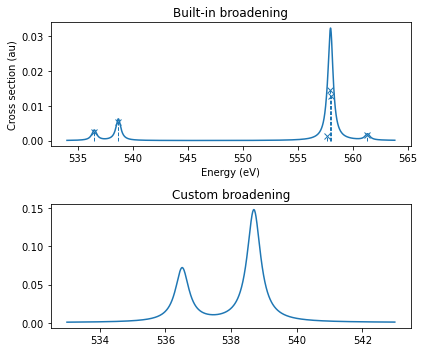

In [9]:
# Print information on eigenstates
print(adc_res.describe())

plt.figure(figsize=(6,5))
# Convolute using functionalities available in gator and adcc
plt.subplot(211); plt.title('Built-in broadening')
adc_res.plot_spectrum()
# Convoluted using information on excitation energies and oscillator strengths
plt.subplot(212); plt.title('Custom broadening')
x,y = au2ev*adc_res.excitation_energy, adc_res.oscillator_strength
xi,yi = lorentzian(x,y,533,543,0.01,0.5); plt.plot(xi,yi)
plt.tight_layout(); plt.show()

The built-in functionality uses a small default broadening (which can be changed) and plots the full region which is resolved, while we might want to focus on lower-energy and larger broadenings (as done in the lower panel). We note that high-energy features can often be a result of a discretized continuum region, as seen by the unphysically intense feature at 558 eV. A larger basis set will flatten out this region, but care should be taken for any analysis of it [refs].

Increasing the basis set to aug-cc-pCVTZ/cc-pVTZ (for oxygen and hydrogen, respectively), we obtain results in good agreement to experiment:


```{figure} ../img/xray/adc_water_xas.svg
---
name: adc_water_xas
---
CVS-ADC(2)-x calculation of the oxygen X-ray absorption spectrum of gaseous water, as compared to experiment. Theoretical spectra has been shifted by 0.37 eV (to account for relativistic effects) and broadened by 0.4 eV.
```


### Spectra from TDDFT eigenstates


```{note} 
To be added.
```


### Spectra from CPP-DFT

With the complex polarization propagator (CPP), also called the damped linear response function, the absorption and dispersion spectrum can be evaluated at arbitrary energies. With this, the X-ray absorption spectrum using KS-DFT can then be directly calculated.

For this, we just need to decide on which energy/frequency region to use, which can be estimated by, e.g.

- Screen more extended energy regions with low step length. This could potentially be done using a smaller basis set.

- With a method lacking relaxation: start the region a few eV below the IP from Koopmans' theorem. This will not work for methods capable of including relaxation, where IP:s from $\Delta$SCF could instead be considered as a first rough estimate (noting that it will work better or worse for different levels of, e.g., ADC theory).

Choosing an energy region of 514-525 eV, using a step length of 0.1 eV and a damping factor of 0.3 eV, we calculate the CPP-DFT (B3LYP) water spectrum as:

In [10]:
# Prepare molecule object
molecule = vlx.Molecule.read_str(water, units='angstrom')
basis    = vlx.MolecularBasis.read(molecule, "6-31G")

# SCF  settings and calculation
scf_drv         = vlx.ScfRestrictedDriver(comm,ostream=silent_ostream)
scf_settings    = {'conv_thresh': 1.0e-6}
method_settings = {'xcfun': 'b3lyp', 'grid_level': 4}
scf_drv.update_settings(scf_settings,method_settings)
scf_drv.compute(molecule, basis)

# Calculate the response at desired frequencies
freqs = np.arange(515.0,525.0,0.1)/au2ev; freqs_str = [str(x) for x in freqs]
cpp_prop = LinearAbsorptionCrossSection({'frequencies': ','.join(freqs_str), 'damping': 0.3/au2ev},
                                        method_settings)
cpp_prop.init_driver(comm, ostream=silent_ostream)
cpp_prop.compute(molecule, basis, scf_drv.scf_tensors)

# Extract the imaginary part of the complex response function and convert to absorption cross section
sigma = []
for w in freqs:
    axx = -cpp_prop.rsp_property['response_functions'][('x', 'x', w)].imag
    ayy = -cpp_prop.rsp_property['response_functions'][('y', 'y', w)].imag
    azz = -cpp_prop.rsp_property['response_functions'][('z', 'z', w)].imag
    alpha_bar = (axx + ayy + azz) / 3.0; sigma.append(4.0 * np.pi * w * alpha_bar / 137.035999)

Resulting spectra can be plotted as raw or splined, for smoother figures:

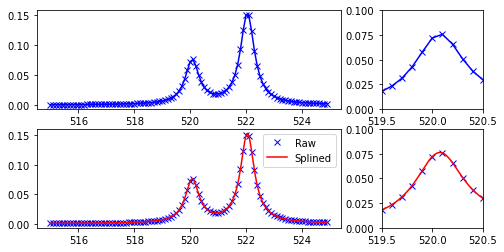

In [11]:
# Make figure with panels of 3:1 width
plt.figure(figsize=(8,4))
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1]) 

# Raw results for full region
plt.subplot(gs[0])
plt.plot(au2ev*freqs,sigma,'bx-')

# Raw results for zoomed in
plt.subplot(gs[1])
plt.plot(au2ev*freqs,sigma,'bx-')
plt.xlim((519.5,520.5)); plt.ylim((0,0.10))

# Raw and splined spectra
plt.subplot(gs[2])
plt.plot(au2ev*freqs,sigma,'bx')
x = np.arange(min(au2ev*freqs),max(au2ev*freqs),0.01)
y = interp1d(au2ev*freqs, sigma, kind='cubic')
plt.plot(x,y(x),'r')
plt.legend(('Raw','Splined'))

# Zoomed in
plt.subplot(gs[3])
plt.plot(au2ev*freqs,sigma,'bx')
plt.plot(x,y(x),'r')
plt.xlim((519.5,520.5)); plt.ylim((0,0.10))
plt.show()

Increasing the basis set size and comparing to [experiment] we get:


```{figure} ../img/xray/dft_water_xas.svg
---
name: dft_water_xas
---
CPP-DFT (B3LYP) X-ray absorption spectrum of water, as compared to experiment. Theoretical spectra shifted by 14.5 eV and broadened by 0.4 eV. Currently aug-cc-pVDZ..
```

```{note} 
Change above to aug-cc-pCVTZ/cc-pVTZ.
```

As can be seen, the absolute excitation energies are significantly of, with a shift of 14.5 eV required to yield an approximate alignment to experiment. Part of this shift is due to lack of relativistic effects (~0.37 eV), and a small discrepancy can be expected due to the use of a limited basis set, but the main part of the error is due to two different effects:

1. Lack of [relaxation](#relaxation), which yield a final state too high in energy and thus shift theoretical spectra upwards in energy.

2. The [self-interaction error](#self-interaction-error-in-dft), which yield an erroneous self-repulsion of the dense core orbitals, and results in too low core-excitation energies.

For B3LYP the total effect of these two errors leads to too low transition energies, meaning that the SIE dominates. By changing the amount of HF exchange this balance will shift and the error eventually becomes positive.

Nevertheless, the obtained CPP-DFT spectrum is in reasonable agreement with experiment once it has been shifted.


### Other approaches

Brief discussion - state-specific, CC, MR, ...

## X-ray emission spectroscopy

Following the creatying of a core-hole, the system will rapidly ($\sim$fs) decay to a valence-hole or valence-excited satte, depending on whether the system is core-ionized or core-excited. These two different intermediate states  are probed when the X-ray pulse is in non-resonant (ionized) or resonant (excited regime), yieldig non-resonant/resonant X-ray emission spectroscopy. This section will focus on the former, with the latter following in the next section.

In the decay process the system gain large amounts of energy which need to be discarded, which can occur by emission of high-energy photon (fluorescence) or higher-lying electron (Auger), with relative probability depending on edge and element. For the *K*-edge the relative probabilities follow:

```{figure} ../img/xray/auger_vs_fluorescent.png
---
name: auger_vs_fluorescent
---
Fluorescence and Auger electron yields as a function of atomic number for *K*-edge core-holes. [Published](https://commons.wikimedia.org/wiki/File:Auger_xray_wiki_in_png_format.png) under CC BY-SA 4.0.
```

As can be seen, Auger decay dominates for light elements, which has impact on both our ability of obtaining well-resolved spectra for these elements, as well as the impact of X-ray damage on biological matter.

In non-resonant XES we then probe the radiative decay of core-ionized states, through which we can probe the (element-specific) nature of the local chemical environment. For light elements the valence space is probed directly, but for heavier elements we obtain a number of different decay channels from the valence region and the outer core region. These lines vary considerably in energy, intensity, and information content [refs]:

1. The $2p \rightarrow 1s$ ($K\alpha_1$ and $K\alpha_2$) is the most intense (due to the large overlap) and of lowest energy, and is relatively insensitive to the valence region.

2. The $3p \rightarrow 1s$ ($K\beta ' $ and $K\beta_{1,3}$) is about an order of magnitude weaker and of higher energy, but more sensitive to the environment.

3. Transitions from the ligand MO:s ($K\beta '' $ and $K\beta_{2,5}$), or valence-to-core (VtC), is the weakest, high-energy features which is most sensitive to the local environment.

The discussion in this tutorial will focus on spectra of lighter elements, as can be modelled with DFT and ADC theory. A good starting point for such calculations include [XPS with ADC/TDDFT].


### Spectra from ADC

One approach for considering X-ray emission spectra is to converge the core-hole state (as above for $\Delta\textrm{SCF}$) and use this core-ionized system as the reference state. The core-decay transition then are the first negative eigenstates of the systemn, such that a standard Davidson calculation can be run on top.

Considering water with ADC(2), the oxygen X-ray emission spectrum is calculated as:

In [12]:
# Construct molecule object
mol       = gto.Mole()
mol.atom  = water
mol.basis = '6-31G'
mol.build()

# Perform neutral SCF calculation
scf_res = scf.UHF(mol)
scf_res.kernel()

# Use above SCF as starting guess, removing core electron and converging with MOM constraint
mo0        = copy.deepcopy(scf_res.mo_coeff)
occ0       = copy.deepcopy(scf_res.mo_occ)
occ0[0][0] = 0.0
scf_ion = scf.UHF(mol)
scf.addons.mom_occ(scf_ion, mo0, occ0)
scf_ion.kernel()

# Perform ADC calculation
adc_xes = adcc.adc2(scf_ion, n_states=4)

converged SCF energy = -75.9838703827193  <S^2> = 6.337153e-12  2S+1 = 1
converged SCF energy = -56.0754789470864  <S^2> = 0.76257805  2S+1 = 2.0125387


/home/thomas/pkg/adcc/adcc/backends/__init__.py:48: UserWarning: Could not check host program psi4 minimal version, since __version__ tag not found. Proceeding anyway.
  "".format(module)


Starting adc2  Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1     8       0.77768   1.2s  [-19.29082067 -19.19940205 -18.96181907 -18.3637012 ]
  2    16     0.0010764  162ms  [-19.44427093 -19.36689642 -19.16826546 -18.57947501]
  3    24    4.4301e-07  274ms  [-19.44429764 -19.3669284  -19.16831914 -18.57954987]
=== Converged ===
    Number of matrix applies:    24
    Total solver time:             1s 642ms


```{note}
There will be some convergence issues if including transitions from very different types, *e.g.* resolving transitions into the core and out to the unoccupied valence region simultaneously. As such, the number of resolved states should remain somewhat limited.
```

The resuls can be printed as a table, or convoluted and plotted using built-in functionalities or a custom broadening. Note that the eigenvalues are negative, and a sing change is appropriate when constructing the spectra.

+--------------------------------------------------------------+
| adc2                                        any ,  converged |
+--------------------------------------------------------------+
|  #        excitation energy     osc str    |v1|^2    |v2|^2  |
|          (au)           (eV)                                 |
|  0      -19.4443     -529.1063   0.0568    0.9548    0.0452  |
|  1     -19.36693      -527.001   0.0458    0.9503   0.04966  |
|  2     -19.16832     -521.5965   0.0419    0.9376   0.06245  |
|  3     -18.57955     -505.5753   0.0031    0.9335   0.06655  |
+--------------------------------------------------------------+



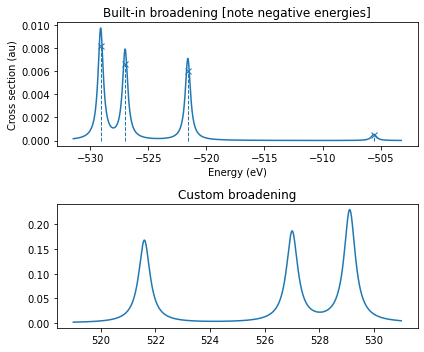

In [13]:
# Print information on eigenstates
print(adc_xes.describe())

plt.figure(figsize=(6,5))
# Convolute using functionalities available in gator and adcc
plt.subplot(211); plt.title('Built-in broadening [note negative energies]')
adc_xes.plot_spectrum()
# Convoluted using information on excitation energies and oscillator strengths
plt.subplot(212); plt.title('Custom broadening')
x,y = -au2ev*adc_xes.excitation_energy, adc_xes.oscillator_strength
xi,yi = lorentzian(x,y,519,531,0.01,0.5); plt.plot(xi,yi)
plt.tight_layout(); plt.show()

Using cc-pCVTZ/cc-pVTZ and comparing to experiment:

```{figure} ../img/xray/overlap_water_xes.svg
---
name: overlap_water_xes
---
ADC(2) water X-ray emission spectrum, as compared to experiment. Theoretical spectra shifted by 0.37 eV (to account for relativistic effects) and broadened by 0.3 eV.
```

While the broadening between the different lines is noticably different, it is clear that the energy spacing and integrated intensities of the features are in good agreement with experiment. Note that the theoretical spectrum is obtained at the ADC(2) level of theory, which has been [shown](https://doi.org/10.1021/acs.jctc.8b01046) to be in better agreement than ADC(2)-x and ADC(3/2) for XES.


### Spectra from TDDFT

```{note}
To be added.
```

### Spectra from ground state MO:s

While we have previously seen that Koopmans' theorem is in significant disagreement with experimental ionization potentials (due to lack of relaxation), it has been noted that the **relative** position of the (valence) MO energies can still be quite reasonable. As such, a computationally very simple approach for modeling X-ray emission spectra has been utilized [refs], in which transition energies are estimated from

\begin{equation}
\Delta E = \epsilon_v - \epsilon_c
\end{equation}

*i.e.* the difference in ground state MO energies. The intensities are taken to be proportional to the dipole moment:

\begin{equation}
f \propto \left| \langle \phi_i \left| \hat{\mu} \right| \phi_c \rangle \right| ^2
\end{equation}

This method is very attractive in its simplicity, requiring only a single ground state calculation and the construction of some dipole moments for a full spectrum calculation. However, the absolute energies will be significantly off, and any differences in relaxation between the different channels will not be included.

Nevertheless, this approach has been noted to yield good (relative) agreement to experimental measurements, and it is very capable of considering even massive molecular systems [refs]. The calculation of it then requires two steps:

- The calculation of ground state wave function and constructing transition energies from MO energy differences:

In [14]:
# SCF calculation
scf_drv          = vlx.ScfRestrictedDriver(comm,ostream=silent_ostream)
scf_settings     = {'conv_thresh': 1.0e-6}
method_settings  = {'xcfun': 'b3lyp', 'grid_level': 4}
scf_drv.update_settings(scf_settings,method_settings)
scf_drv.compute(molecule, basis)

# Extract orbital energies and number of occupied MOs
orbital_energies = scf_drv.scf_tensors['E']
nocc = molecule.number_of_alpha_electrons()
print('Occupied MO energies:',au2ev*orbital_energies[:nocc])

# Define probed core MO(s) and calculate energy differences
n_core = 0
overlap_energy = []
for n_mo in np.arange(nocc):
    if n_mo != n_core:
        overlap_energy.append(au2ev*(orbital_energies[n_mo]-orbital_energies[n_core]))

Occupied MO energies: [-520.65709504  -27.68789281  -14.39952883   -9.70377533   -7.94952959]


- The calculation of dipole moments between the occupied states:

In [15]:
# Load required functionalities
dipole_drv      = vlx.ElectricDipoleIntegralsDriver(comm)
dipole_matrices = dipole_drv.compute(molecule, basis)
C = scf_drv.scf_tensors['C'] # MO coefficients

# Calculated dipole moments and convert to MO basis
x_ao = dipole_matrices.x_to_numpy(); x_mo = np.matmul(C.T, np.matmul(x_ao, C))
y_ao = dipole_matrices.y_to_numpy(); y_mo = np.matmul(C.T, np.matmul(y_ao, C))
z_ao = dipole_matrices.z_to_numpy(); z_mo = np.matmul(C.T, np.matmul(z_ao, C))

# Calculate transition dipole moments and square modulus
xx,yy,zz,osc_str = [],[],[],[]
for n_mo in np.arange(nocc):
    if n_mo != n_core:
        x_tmp,y_tmp,z_tmp = x_mo[n_core,n_mo],y_mo[n_core,n_mo],z_mo[n_core,n_mo]
        xx.append(x_tmp); yy.append(y_tmp); zz.append(z_tmp)
        osc_str.append(x_tmp**2+y_tmp**2+z_tmp**2)

From this we get the stick spectrum, which is printed with its decomposition. Further, it can be convoluted with a lorentzian, here focusing on the high-energy features.

Energy   Osc. str.   x-component   y-component   z-component
492.969   0.00022      0.00000      -0.00000      -0.01478
506.258   0.00238     -0.04878       0.00000       0.00000
510.953   0.00255     -0.00000      -0.00000       0.05050
512.708   0.00342     -0.00000       0.05848       0.00000


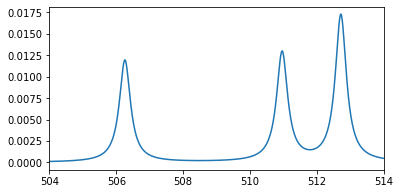

In [16]:
print('Energy   Osc. str.   x-component   y-component   z-component')
for i in np.arange(len(overlap_energy)):
    e,os,x,y,z = overlap_energy[i],osc_str[i],xx[i],yy[i],zz[i]
    print('{:.3f}  {:8.5f}     {:8.5f}      {:8.5f}      {:8.5f}'.format(e,os,x,y,z))

plt.figure(figsize=(6,3))
x,y = overlap_energy,osc_str
xi,yi = lorentzian(x,y,min(x)-5,max(x)+5,0.01,0.4)
plt.plot(xi,yi)
plt.xlim((504,514))
plt.show()

Using cc-pCVTZ/cc-pVTZ and comparing to experiment


```{figure} ../img/xray//overlap_water_xes.svg
---
name: /overlap_water_xes
---
DFT (B3LYP) overlap X-ray emission spectrum of water, as compared to experiment. Theoretical spectra shifted to approximately align the high-energy feature, and broadened by 0.3 eV.
```

The resulting spectrum is quite off in energy, but the relative agreement to experiment is quite impressive.


### Other approaches

Brief discussion - CC, ...

## Resonant inelastic X-ray scattering

```{note}
- To be added.

- One-step versus two-step.
```

Here focus on the electronic part of he RIXS plane.


### Two-step approach with ADC

In [115]:
# Construct molecule object
mol       = gto.Mole()
mol.atom  = water
mol.basis = '6-31G'
mol.build()
# Perform neutral SCF calculation
scf_res = scf.UHF(mol)
scf_res.kernel()
# XAS
adc_xas = adcc.cvs_adc2(scf_res, n_states=5,core_orbitals=1)

adc_rixs = []
for n in [5,6]:
    mo0        = copy.deepcopy(scf_res.mo_coeff)
    occ0       = copy.deepcopy(scf_res.mo_occ)
    occ0[0][0] = 0.0; occ0[0][n] = 1.0
    scf_ion = scf.UHF(mol); scf.addons.mom_occ(scf_ion, mo0, occ0)
    scf_ion.kernel()
    adc_rixs.append(adcc.adc2(scf_ion, n_states=4))

converged SCF energy = -75.9838703827191  <S^2> = 6.3398176e-12  2S+1 = 1
Starting cvs-adc2  Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1     8        1.6222  841ms  [20.26123431 20.31992537 20.32302691 20.3464984  20.77599022]
  2    16      0.059729  165ms  [19.77470975 19.80230856 19.84312303 19.87818817 20.5373859 ]
  3    24     0.0025223  286ms  [19.75718509 19.78334186 19.84056229 19.86585919 20.53732181]
  4    32    0.00064877  237ms  [19.75656768 19.78236576 19.84024749 19.86584883 20.53732181]
  5    38    2.0368e-05  272ms  [19.756435   19.78211629 19.84024749 19.86584882 20.53732181]
=== Converged ===
    Number of matrix applies:    38
    Total solver time:             1s 823ms


In [120]:
print(adc_xas.describe())
print(adc_rixs[0].describe())
print(adc_rixs[1].describe())

XAS
+--------------------------------------------------------------+
| cvs-adc2                                    any ,  converged |
+--------------------------------------------------------------+
|  #        excitation energy     osc str    |v1|^2    |v2|^2  |
|          (au)           (eV)                                 |
|  0      19.75644         537.6   0.0000    0.8488    0.1512  |
|  1      19.78212      538.2988   0.0166    0.8393    0.1607  |
|  2      19.84025      539.8806   0.0000    0.8617    0.1383  |
|  3      19.86585      540.5773   0.0356    0.8518    0.1482  |
|  4      20.53732       558.849   0.0000    0.9255   0.07451  |
+--------------------------------------------------------------+


LUMO
+--------------------------------------------------------------+
| adc2                                        any ,  converged |
+--------------------------------------------------------------+
|  #        excitation energy     osc str    |v1|^2    |v2|^2  |
|          (au

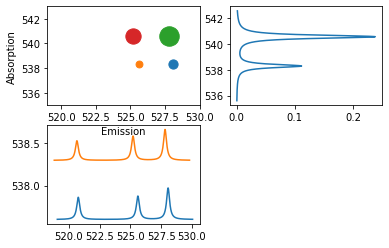

In [123]:
plt.figure()
plt.subplot(222)
x,y = au2ev*adc_xas.excitation_energy, adc_xas.oscillator_strength
xi,yi = lorentzian(x,y,min(x)-2,min(x)+5,0.01,0.3)
plt.plot(yi,xi)
plt.subplot(223)
x,y = -au2ev*adc_rixs[0].excitation_energy, adc_rixs[0].oscillator_strength
xi,yi = lorentzian(x,y,x[1]-9,x[1]+2,0.01,0.3)
plt.plot(xi,yi+au2ev*adc_xas.excitation_energy[0])
x,y = -au2ev*adc_rixs[1].excitation_energy, adc_rixs[1].oscillator_strength
xi,yi = lorentzian(x,y,x[1]-9,x[1]+2,0.01,0.3)
plt.plot(xi,yi+au2ev*adc_xas.excitation_energy[1])

plt.subplot(221)
# LUMO
indx = 1
f1xas = au2ev*adc_xas.excitation_energy[indx]
f1xes = -au2ev*adc_rixs[0].excitation_energy[1]
f1int = adc_xas.oscillator_strength[indx]*adc_rixs[0].oscillator_strength[1]
f2xas = f1xas
f2xes = -au2ev*adc_rixs[0].excitation_energy[2]
f2int = adc_xas.oscillator_strength[indx]*adc_rixs[0].oscillator_strength[2]
plt.plot(f1xes,f1xas,'o',markersize=10000*f1int)
plt.plot(f2xes,f2xas,'o',markersize=10000*f2int)
# LUMO+1
indx = 3
f1xas = au2ev*adc_xas.excitation_energy[indx]
f1xes = -au2ev*adc_rixs[1].excitation_energy[1]
f1int = adc_xas.oscillator_strength[indx]*adc_rixs[1].oscillator_strength[1]
f2xas = f1xas
f2xes = -au2ev*adc_rixs[1].excitation_energy[2]
f2int = adc_xas.oscillator_strength[indx]*adc_rixs[1].oscillator_strength[2]
plt.plot(f1xes,f1xas,'o',markersize=10000*f1int)
plt.plot(f2xes,f2xas,'o',markersize=10000*f2int)
plt.ylim((535,543)); plt.xlim((519,530))
plt.xlabel('Emission'); plt.ylabel('Absorption')
plt.show()

### Two-step approach with TDDFT

```{note}
To be added.
```


### Dirac-Kramer-Heisenberg with ADC

```{note}
To be added.
```


### Other approaches

Overlap approach...?


## Analysis

For the analysis of obtained spectra we will focus on the carbon X-ray absorption spectrum of vinylfluoride. Some analysis on the water X-ray emission spectrum will also be included, but as XES is generally easier to analyse (fewer states, unoccupied state of relatively different energies, etc), focus will be on XAS.

Vinulfluride (C$_2$H$_3$F) is a singly-substituted ethene derivate, which possess large shifts in features for the -CHF site, due to interaction with the very electronegative fluorine. This *chemical shift* is significant and a strong indicator of the local chemical environment. This can be seen in the [experimental spectra] of ethene, vinylfluoride, and 1,1-difluoroethene:


```{figure} ../img/xray/expt_ethene.svg
---
name: /expt_ethene
---
Carbon X-ray absorption spectra of ethene and two substituted derivates. Marking position (and number of contributing carbon sites) of two $1s \rightarrow \pi^{\ast}$ transitions.
```

The position (and number of) $\pi^{\ast}$-resonances are labelled, and we see that a single substitution yield a shift of about 2 eV, and double susbtitution (at the same site) of about 4 eV.

Calculating the vinylfluoride spectrum using CVS-ADC(2)-x:

In [17]:
vinyl   = """
 C     0.000000    -0.246412    -1.271068
 C     0.000000     0.457081    -0.154735
 F     0.000000    -0.119195     1.052878
 H     0.000000     0.272328    -2.210194
 H     0.000000    -1.319906    -1.249847
 H     0.000000     1.530323    -0.095954
"""

# SCF calculation
struct  = gator.get_molecule(vinyl)
basis   = gator.get_molecular_basis(struct,'6-31G')
scf_res = gator.run_scf(struct,basis)

# CVS space with three lowest MOs
adc_xas = gator.run_adc(struct,basis,scf_res,method='cvs-adc2x',singlets=10,core_orbitals=[1,2,3])

SCF converged in 7 iterations.
Total Energy: -176.8261179602 au
                                                                                                                          
                                        Algebraic Diagrammatic Construction (ADC)                                         
                                                                                                                          
                               ADC method                   : cvs-adc2x                                                   
                               Number of Singlet States     : 10                                                          
                               CVS-ADC, Core Orbital Space  : 1 2 3                                                       
                               Convergence threshold        : 1.0e-06                                                     
                                                                           

/home/thomas/pkg/adcc/adcc/backends/__init__.py:48: UserWarning: Could not check host program psi4 minimal version, since __version__ tag not found. Proceeding anyway.
  "".format(module)


Starting cvs-adc2x singlet Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1    20        0.8829  648ms  [10.90469033 11.01274771 11.12186863 11.13574568 11.15427194 11.22366087
 11.2857491 ]
  2    40       0.10942   1.3s  [10.57182274 10.67941657 10.72935934 10.75067853 10.81315143 10.81361485
 10.84327123]
  3    60     0.0061127   1.8s  [10.55781863 10.63999235 10.70185702 10.72113055 10.76319341 10.78079701
 10.81308683]
  4    80    0.00093309   2.3s  [10.55663466 10.63712206 10.69959324 10.71942116 10.76026737 10.77786443
 10.81039384]
  5   100     0.0001655   2.5s  [10.55654765 10.63677648 10.69916368 10.71927018 10.75988036 10.77734383
 10.81003668]
=== Restart ===
  6    40     2.647e-05   2.3s  [10.55654333 10.63675296 10.69912625 10.71925908 10.75984683 10.77729435
 10.81000543]
  7    60    7.3013e-06   2.0s  [10.55654286 10.63674998 10.69911822 10.71925747 10.75983942 10.77728362
 10.80999969]
  8    80    1.4836e-06   2.5s  [10.55654283 10.63674965 10.

And with CPP-DFT (B3LYP):

In [18]:
molecule = vlx.Molecule.read_str(vinyl, units='angstrom')
basis    = vlx.MolecularBasis.read(molecule, "6-31G")
scf_drv = vlx.ScfRestrictedDriver(comm,ostream=silent_ostream)
scf_settings  = {'conv_thresh': 1.0e-6}
method_settings = {'xcfun': 'b3lyp', 'grid_level': 4}
scf_drv.update_settings(scf_settings,method_settings); scf_drv.compute(molecule, basis)
freqs = np.arange(272.0,285.0,0.25)/au2ev; freqs_str = [str(x) for x in freqs]
cpp_prop = LinearAbsorptionCrossSection({'frequencies': ','.join(freqs_str), 'damping': 0.4/au2ev}
                                         ,method_settings)
cpp_prop.init_driver(comm, ostream=silent_ostream)
cpp_prop.compute(molecule, basis, scf_drv.scf_tensors)
sigma = []
for w in freqs:
    axx = -cpp_prop.rsp_property['response_functions'][('x', 'x', w)].imag
    ayy = -cpp_prop.rsp_property['response_functions'][('y', 'y', w)].imag
    azz = -cpp_prop.rsp_property['response_functions'][('z', 'z', w)].imag
    alpha_bar = (axx + ayy + azz) / 3.0; sigma.append(4.0 * np.pi * w * alpha_bar / 137.035999)

The resulting spectra are shown below, and look quite similar (although with a large difference in absolute energy):

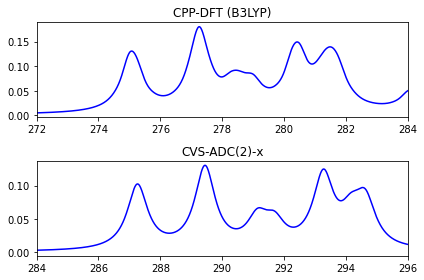

In [19]:
plt.figure(figsize=(6,4))
plt.subplot(211); plt.title('CPP-DFT (B3LYP)')
x = np.arange(min(au2ev*freqs),max(au2ev*freqs),0.01)
y = interp1d(au2ev*freqs, sigma, kind='cubic')
plt.plot(x,y(x),'b')
plt.xlim(272,284)

plt.subplot(212); plt.title('CVS-ADC(2)-x')
x,y = au2ev*adc_xas.excitation_energy, adc_xas.oscillator_strength
xi,yi = lorentzian(x,y,280,300,0.01,0.8); plt.plot(xi,yi,'b')
plt.xlim(284,296)
plt.tight_layout(); plt.show()

### Amplitudes

For eigenstates we can study the amplitudes of the eigenvectors to see the contributions in the different excited states. For CPP, a similar analysis on response vectors can be conducted, but this might be made more difficult if th density of states is high and the mixing of cointributions to the response at investigated frequencies is thus significant.

Fro the ADC calculations there is a function `state.describe_amplitudes`, which print the amplitudes using one of three formats, controlled by `index_format`. The amplitudes are printed when above a `tolerance` threshold, and splitting the returning string according to `state` and printing the first two states, we get:

In [21]:
print('From \'hf\' format, which yield MO number:')
des_amp    = adc_xas.describe_amplitudes(tolerance=0.1,index_format='hf')
split_line = '\n\n'
tmp_amp    = des_amp.split(split_line)
print(tmp_amp[1])
print(tmp_amp[2])
print()

print('\nFirst transition from \'adcc\' format, with indexing as used in adcc:')
des_amp    = adc_xas.describe_amplitudes(tolerance=0.1,index_format='adcc')
split_line = '\n\n'
tmp_amp    = des_amp.split(split_line)
print(tmp_amp[1])
print()


print('\nFirst transition from \'homolumo\' format, which using HOMO/LUMO/HOCO format:')
des_amp    = adc_xas.describe_amplitudes(tolerance=0.1,index_format='homolumo')
split_line = '\n\n'
tmp_amp    = des_amp.split(split_line)
print(tmp_amp[1])

From 'hf' format, which yield MO number:
+---------------------------------------+
| State   1 ,      10.63675 au          |
+---------------------------------------+
|   1     ->  12      a ->a      +0.601 |
|   1     ->  22      a ->a      -0.105 |
|  11   1 ->  12  12  ab->ab     -0.149 |
+---------------------------------------+
| State   2 ,      10.69912 au          |
+---------------------------------------+
|   2     ->  13      a ->a        -0.5 |
|   2     ->  15      a ->a      +0.273 |
|   2     ->  14      a ->a       -0.22 |


First transition from 'adcc' format, with indexing as used in adcc:
+-------------------------------------------------------+
| State   1 ,      10.63675 au,      289.4407 eV        |
+-------------------------------------------------------+
| (o2  1)         -> (v1  0)          a ->a      +0.601 |
| (o2  1)         -> (v1 10)          a ->a      -0.105 |
| (o1  8) (o2  1) -> (v1  0) (v1  0)  ab->ab     -0.149 |


First transition from 'homolumo' fo

From this, it is clear that the two first transitions originates in two different MOs, which corresponds to the -CH$_2$ and -CHF atoms, respectively. The transitions are dominated by single-excitations to the LUMO and LUMO+1, with largest relaxation contributions coming from the HOMO.


### Decomposition of spectra

For a more visual illustration, we can plot the spectra as decomposed according to atomic contributions and polarization of incoming radiation. 

#### Atomic contributions

Decomposing according to atomic contributions provides information on which core orbitals that contribute to which features. For vinylfluoride, this can be done by performing CVS calculations with tailored CVS spaces for each carbon site:

In [22]:
struct  = gator.get_molecule(vinyl)
basis   = gator.get_molecular_basis(struct,'6-31G')
scf_res = gator.run_scf(struct,basis)
adc_chf = gator.run_adc(struct,basis,scf_res,method='cvs-adc2x',singlets=6,core_orbitals=[2])
adc_ch2 = gator.run_adc(struct,basis,scf_res,method='cvs-adc2x',singlets=6,core_orbitals=[3])

SCF converged in 7 iterations.
Total Energy: -176.8261179602 au
                                                                                                                          
                                        Algebraic Diagrammatic Construction (ADC)                                         
                                                                                                                          
                               ADC method                   : cvs-adc2x                                                   
                               Number of Singlet States     : 6                                                           
                               CVS-ADC, Core Orbital Space  : 2                                                           
                               Convergence threshold        : 1.0e-06                                                     
                                                                           

/home/thomas/pkg/adcc/adcc/backends/__init__.py:48: UserWarning: Could not check host program psi4 minimal version, since __version__ tag not found. Proceeding anyway.
  "".format(module)


Starting cvs-adc2x singlet Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1    12       0.83779  363ms  [10.95566726 11.09723173 11.22363262 11.38716475 11.45152996 11.46601874]
  2    24        0.2046  654ms  [10.65380288 10.80467648 10.83594988 10.92569049 11.03253872 11.14745754]
  3    36      0.010306  769ms  [10.63808994 10.78045883 10.81247902 10.84957006 10.93904758 11.01133284]
  4    48     0.0013397  989ms  [10.63691445 10.77791559 10.81035773 10.84602802 10.93142281 11.00480161]
  5    60     0.0001776   1.1s  [10.63683717 10.77744923 10.81011882 10.8455034  10.93044828 11.00389063]
=== Restart ===
  6    24    5.7686e-05  920ms  [10.63683012 10.7774054  10.81009624 10.84544999 10.93033759 11.00374539]
  7    36    3.3654e-05  782ms  [10.63682842 10.7773967  10.81009167 10.84543763 10.93029998 11.00366411]
  8    48    1.3715e-05   1.0s  [10.63682822 10.7773952  10.81009101 10.84543576 10.9302912  11.00363115]
  9    60    3.1896e-06   1.2s  [10.6368282  

From which the spectra can be decomposed:

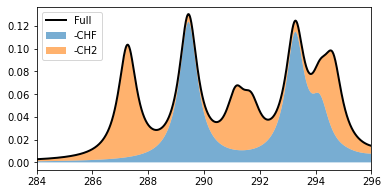

In [23]:
plt.figure(figsize=(6,3))

# Spectrum from -CHF 
x1,y1 = au2ev*adc_chf.excitation_energy, adc_chf.oscillator_strength
x1i,y1i = lorentzian(x1,y1,280,300,0.01,0.8)

# Spectrum from -CH2
x2,y2 = au2ev*adc_ch2.excitation_energy, adc_ch2.oscillator_strength
x2i,y2i = lorentzian(x2,y2,280,300,0.01,0.8)

# Plotting line spectra for full, area spectra for contributions
plt.plot(x2i,y1i+y2i,'k-',linewidth=2.0)
plt.fill_between(x2i, 0, y1i,alpha=0.6)
plt.fill_between(x2i, y1i, y1i+y2i,alpha=0.6)

plt.legend(('Full','-CHF','-CH2'),loc='upper left')
plt.xlim(284,296)
plt.show()

This manner of decomposing the atomic contributions should be taken with some care, as it involves explicit calculation of all atomic sites, which:

1. Requires a larger number of calculations, and care should be taken so that a region in which some states (e.g. for -CHF) are converged into, but not other (e.g. -CH$_2$).

2. Does not strictly fit with the CVS philosophy, which uses the large separation in energy and spatial extend as a basis for separation. Energy separation can now be rather small, and for some systems degeneracies and near-degeneracies may lead to delocalized core orbitals. If so, all delocalized sites must be included in the same CVS space.

Nevertheless, the lower computational cost per calculation of doing this decomposition may make it worth it.

Alternatively, using the full space eigenvectors, we can perform a decomposition as...

```{note}
Do full space eigenvector decomposition and compare to above.

- Either learn how eigenstates are constructed, or just split and divide describe_amplitude results.
```

Performing the same analysis with CPP-DFT, we decompose the solution vectors:

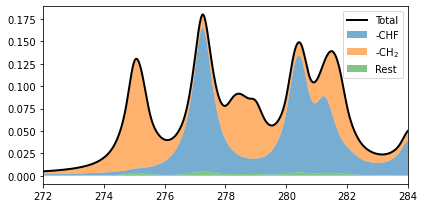

In [24]:
# Number of occupied and unoccupied (alpha) MOs
nocc  = molecule.number_of_alpha_electrons()
nvirt = scf_drv.mol_orbs.number_mos() - nocc

# Extract solution vectors
solution_vecs = cpp_prop.get_property('solutions')
x_solution,y_solution,z_solution = [],[],[]
for w in freqs:
    x_solution.append(solution_vecs[('x',w)])
    y_solution.append(solution_vecs[('y',w)])
    z_solution.append(solution_vecs[('z',w)])
x_solution,y_solution,z_solution = np.array(x_solution),np.array(y_solution),np.array(z_solution)

# Extract polarization-resolved response
sX,sY,sZ = [],[],[]
for w in freqs:
    axx = -cpp_prop.rsp_property['response_functions'][('x', 'x', w)].imag
    ayy = -cpp_prop.rsp_property['response_functions'][('y', 'y', w)].imag
    azz = -cpp_prop.rsp_property['response_functions'][('z', 'z', w)].imag
    sX.append(4.0/3.0 * np.pi * w * axx / 137.035999)
    sY.append(4.0/3.0 * np.pi * w * ayy / 137.035999)
    sZ.append(4.0/3.0 * np.pi * w * azz / 137.035999)

# Create empty object of dimension nocc (to add spectrum for each occupied)
spec_comp = []
for occ in np.arange(0,nocc): spec_comp.append([])
    
# Appending spec_comp object with decomposed response
for i in np.arange(len(freqs)):
    x_tmp = x_solution[i]; y_tmp = y_solution[i]; z_tmp = z_solution[i]
    for occ in np.arange(nocc):
        comp_X = np.sum(np.abs(np.imag(x_tmp[occ*nvirt : (occ+1)*nvirt]))) / np.sum(np.abs(np.imag(x_tmp[:])))
        comp_Y = np.sum(np.abs(np.imag(y_tmp[occ*nvirt : (occ+1)*nvirt]))) / np.sum(np.abs(np.imag(y_tmp[:])))
        comp_Z = np.sum(np.abs(np.imag(z_tmp[occ*nvirt : (occ+1)*nvirt]))) / np.sum(np.abs(np.imag(z_tmp[:])))
        spec_comp[occ].append((comp_X*sX[i]+comp_Y*sY[i]+comp_Z*sZ[i]))

# Extract contribution of two carbon atoms
cont_chf  = np.array(spec_comp[1])
cont_ch2  = np.array(spec_comp[2])
cont_full = sigma

plt.figure(figsize=(6,3))
# Create splines spectra for each component
x     = np.arange(min(au2ev*freqs),max(au2ev*freqs),0.01)
ychf  = interp1d(au2ev*freqs, cont_chf,  kind='cubic')
ych2  = interp1d(au2ev*freqs, cont_ch2,  kind='cubic')
yfull = interp1d(au2ev*freqs, cont_full, kind='cubic')
# Spectrum from the non-carbon atoms
yrest = yfull(x) - ychf(x) - ych2(x)
# Plot full spectrum
plt.plot(x,yfull(x),'k-',linewidth=2)
# Plot components
plt.fill_between(x, yrest, yrest+ychf(x), alpha=0.6)
plt.fill_between(x, yrest+ychf(x), yrest+ych2(x)+ychf(x), alpha=0.6)
plt.fill_between(x, 0, yrest, alpha=0.6)

plt.legend(('Total','-CHF',r'-CH$_2$','Rest'))
plt.xlim((272,284))
plt.tight_layout()

We see that the first two features corresponds to transitions from two different MOs, which here are to -CH$_2$ and -CHF.


#### Polarization dependence

- Discuss the possibilities of using polarization-sensitive measurements for investigating local structure.

Resolving the Cartesian components of the response vectors is quite straightforward, with ADC:

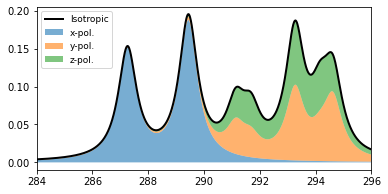

In [28]:
# Extract Cartesian components from ADC state (here skipping the prefactors)
adc_sX,adc_sY,adc_sZ = [],[],[]
adc_freq = adc_xas.excitation_energy
indx = 0
for w in adc_freq:
    tmp_tms = adc_xas.transition_dipole_moment[indx]
    adc_sX.append(w*tmp_tms[0]**2)
    adc_sY.append(w*tmp_tms[1]**2)
    adc_sZ.append(w*tmp_tms[2]**2)
    indx += 1

plt.figure(figsize=(6,3))
# Broadened spectra for each component
xmin,xmax = 284,296
x,y   = au2ev*adc_freq, adc_sX
xX,yX = lorentzian(x,y,xmin,xmax,0.01,0.8)
x,y   = au2ev*adc_freq, adc_sY
xY,yY = lorentzian(x,y,xmin,xmax,0.01,0.8)
x,y   = au2ev*adc_freq, adc_sZ
xZ,yZ = lorentzian(x,y,xmin,xmax,0.01,0.8)
# Plot it
plt.plot(xX,yX+yY+yZ,'k-',linewidth=2)
plt.fill_between(xX, 0, yX,alpha=0.6)
plt.fill_between(xX, yX, yX+yY,alpha=0.6)
plt.fill_between(xX, yX+yY, yX+yY+yZ,alpha=0.6)

plt.legend(('Isotropic','x-pol.','y-pol.','z-pol.'),fontsize=9)
plt.xlim((xmin,xmax))
plt.show()

And for CPP-DFT:

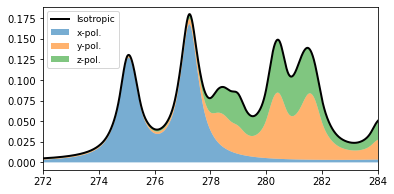

In [29]:
plt.figure(figsize=(6,3))
x = np.arange(min(au2ev*freqs),max(au2ev*freqs),0.01)
yX = interp1d(au2ev*freqs, sX, kind='cubic')
yY = interp1d(au2ev*freqs, sY, kind='cubic')
yZ = interp1d(au2ev*freqs, sZ, kind='cubic')
plt.plot(x,yX(x)+yY(x)+yZ(x),'k-',linewidth=2)
plt.fill_between(x, 0, yX(x), alpha=0.6)
plt.fill_between(x, yX(x), yX(x)+yY(x), alpha=0.6)
plt.fill_between(x, yX(x)+yY(x), yX(x)+yY(x)+yZ(x), alpha=0.6)
plt.legend(('Isotropic','x-pol.','y-pol.','z-pol.'),fontsize=9)
plt.xlim((272,284))
plt.show()

We see that the first two transitions are out-of-plane, being $\pi^{\ast}$.

Using a larger basis set of aug-cc-pCVT/cc-pVTZ and comparing to experiment, we obtain:


```{figure} ../img/xray/vinyl_decomp.svg
---
name: vinyl_decomp
---
ADC and TDDFT, atomic and polarization
```

```{note}
Fix this.
```

Looks pretty good - compares well. Maybe improves with CAM-B3LYP (or evem CAM100%-B3LYP), so could potentially change that further down the line.

### Visualization

```{note}
Could add, e.g.,

- Electron/hole densities

- Attachment/detachment densities

    - Compare to electron/hole - relaxation

- NTO:s?

- MOs?
```

### Descriptors

```{note}
Could add, e.g.,

- Electron/hole sizes etc

- Attachment/detachment sizes etc

- v2, R, ...
```

## Larger systems

### Valence-to-core XES

Suitable TM-complex with minimal static correlation

1. Overlap

2. TDDFT(?)

3. ADC?


### XAS of uracil

Maybe uracil or similar:

1. Tailor CVS space for ADC ('cost-saving measures')

2. Gas phase spectra

3. Spectra with PE

Might include massive system with DFT as well.


### XES of uracil

Maybe uracil again.

1. Gas phase

2. Environment with PE

Could potentially consider some massive system - TDDFT versus overlap.


### Coupling to molecular dynamics

Some system...

1. Dynamics + XAS

2. Dynamics + XES

3. Inclusion of environment?

4. Core-hole dynamics with some model?

## Transient X-ray spectroscopy

```{note}
Longer-term goal.

- Two-step approach

- Coupling
```

## Self-interaction error in DFT

For a single-electron systems the following equality should hold for the two-electron terms:

$$
J[\rho] + E_{xc} [\rho] = 0.0
$$

This cancellation is achieved for, e.g. Hartree–Fock theory, but for any approximate functionals in DFT it will instead result in an erronous contribution to the energy. DFT-based methods generally suffer from self-interaction error (SIE), which corresponds to the sum of Coulomb and exchange self-interactions that remain because of the use of approximate exchange functionals. In more detail, the Coulomb self-repulsion of each electron included in the Coulomb operator is exactly canceled by the nonlocal exchange self-attraction in Hartree--Fock theory, but this is no longer the case when the exchange operator is replaced by an approximate exchange functional.

Consider the ionization potential of water, as calculated with MO energy and $\Delta\textrm{SCF}$. Former a reasonable representative of IP from TDDFT XAS calculation.

In [304]:
# Prepare molecule object
mol       = gto.Mole(); mol.atom  = water; mol.basis = '6-31G'; mol.build()

# HF exchange and creating result containers
hf_exc  = [0.0,0.25,0.50,0.75,1.0]
hf_blyp,hf_pbe = [[],[]], [[],[]]

for h_x in hf_exc:
    ###### BxLYP (Slater exchange 0.08, except when HF i 1.00)
    if h_x == 1.0: s_x = 0.00
    else:          s_x = 0.08 
    b_x      = 1.00 - h_x - s_x
    v_e, v_l = 0.19, 0.81
    # Neutral calculation
    dft_res    = scf.UKS(mol)
    dft_res.xc = f'{h_x:} * HF + {s_x:} * Slater + {b_x:} * B88, {v_l:} * LYP + {v_e:} * VWN'
    dft_res.kernel()
    # Core-hole calculation
    mo0  = copy.deepcopy(dft_res.mo_coeff); occ0 = copy.deepcopy(dft_res.mo_occ); occ0[0][0] = 0.0; dft_ion = scf.UKS(mol)
    dft_ion.xc = f'{HF_X:} * HF + {LDA_X:} * LDA + {B88_X:} * B88, {LYP_C:} * LYP + {VWN_C:} * VWN'
    scf.addons.mom_occ(dft_ion, mo0, occ0); dft_ion.kernel()
    # Extract results
    hf_blyp[0].append(au2ev*(dft_ion.energy_tot() - dft_res.energy_tot()))
    hf_blyp[1].append(-au2ev*dft_res.mo_energy[0][0])
    ###### PBEx
    p_x = 1.0 - h_x
    # Neutral calculation
    dft_res    = scf.UKS(mol)
    dft_res.xc = f'{h_x:} * HF + {p_x:} * PBE, PBE'
    dft_res.kernel()
    # Core-hole calculation
    mo0  = copy.deepcopy(dft_res.mo_coeff); occ0 = copy.deepcopy(dft_res.mo_occ);  occ0[0][0] = 0.0; dft_ion = scf.UKS(mol)
    dft_ion.xc = f'{h_x:} * HF + {p_x:} * PBE, PBE'
    scf.addons.mom_occ(dft_ion, mo0, occ0); dft_ion.kernel()
    # Extract results
    hf_pbe[0].append(au2ev*(dft_ion.energy_tot() - dft_res.energy_tot()))
    hf_pbe[1].append(-au2ev*dft_res.mo_energy[0][0])

converged SCF energy = -76.3570352138422  <S^2> = 9.876544e-13  2S+1 = 1
converged SCF energy = -56.4125421194361  <S^2> = 0.75441021  2S+1 = 2.0044054
converged SCF energy = -76.2984404502067  <S^2> = 6.9277917e-13  2S+1 = 1
converged SCF energy = -56.3921764305246  <S^2> = 0.75419443  2S+1 = 2.00419
converged SCF energy = -76.3458605029087  <S^2> = 1.9799273e-11  2S+1 = 1
converged SCF energy = -56.4125421194361  <S^2> = 0.75441021  2S+1 = 2.0044054
converged SCF energy = -76.3012084721052  <S^2> = 3.3217873e-12  2S+1 = 1
converged SCF energy = -56.3896010586894  <S^2> = 0.7552122  2S+1 = 2.0052054
converged SCF energy = -76.3352647255066  <S^2> = 1.375966e-11  2S+1 = 1
converged SCF energy = -56.4125421194361  <S^2> = 0.75441021  2S+1 = 2.0044054
converged SCF energy = -76.304577252447  <S^2> = 2.9345415e-11  2S+1 = 1
converged SCF energy = -56.3873473076527  <S^2> = 0.75643162  2S+1 = 2.0064213
converged SCF energy = -76.325199834941  <S^2> = 1.0948575e-11  2S+1 = 1
converged SCF e

With results:

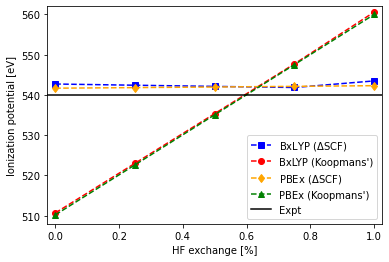

In [315]:
plt.figure(figsize=(6,4))
plt.plot(hf_exc,hf_blyp[0],'bs--')
plt.plot(hf_exc,hf_blyp[1],'ro--')
plt.plot(hf_exc,hf_pbe[0],'d--',color='orange')
plt.plot(hf_exc,hf_pbe[1],'g^--')
plt.plot([-0.1,1.1],[539.9,539.9],'k-')
plt.legend((r'BxLYP ($\Delta$SCF)','BxLYP (Koopmans\')',r'PBEx ($\Delta$SCF)','PBEx (Koopmans\')','Expt'))
plt.xlim((-0.025,1.025)); plt.ylim((508,562.))
plt.xlabel('HF exchange [%]')
plt.ylabel('Ionization potential [eV]')
plt.show()

As can be seen, the IP error from MO energies (which scales as the XAS error) does not appreciably depend on the functional, save for HF exchange.

- Radial distribution for functionals?

- Calculate SIE?

## Relativity

Total relativistic and correlation corrections as a function of Z

not additive with correlation

### Scalar relativistic effects

#### For ionization potentials

In [34]:
z, rel_mo, rel_delta, rel_e = [],[],[],[]
for i in np.arange(2,20,2):
    struct = str(i)+'   0.0  0.0  0.0'
    mol = gto.Mole(); mol.atom  = struct; mol.basis = 'unc-ccpvdz'; mol.build()
    scf_nr  = scf.UHF(mol); scf_nr.kernel()
    scf_rel = scf.UHF(mol).x2c1e(); scf_rel.kernel()
    z.append(i)
    rel_mo.append(27.2114*(scf_nr.mo_energy[0][0]-scf_rel.mo_energy[0][0]))
    mo0 = copy.deepcopy(scf_nr.mo_coeff); occ0 = copy.deepcopy(scf_nr.mo_occ); occ0[0][0] = 0.0
    ion_nr  = scf.UHF(mol); scf.addons.mom_occ(ion_nr, mo0, occ0);  ion_nr.kernel()
    ion_rel = scf.UHF(mol).x2c1e();     scf.addons.mom_occ(ion_rel, mo0, occ0);     ion_rel.kernel()
    rel_delta.append(27.2114*((ion_rel.e_tot-scf_rel.e_tot)-(ion_nr.e_tot-scf_nr.e_tot)))
    rel_e.append(27.2114*(ion_rel.e_tot-scf_rel.e_tot))

converged SCF energy = -2.85516047724517  <S^2> = 1.3322676e-15  2S+1 = 1
converged SCF energy = -2.85525304501235  <S^2> = 1.110223e-15  2S+1 = 1
converged SCF energy = -1.99426858617921  <S^2> = 0.75  2S+1 = 2
converged SCF energy = -1.99436880481848  <S^2> = 0.75  2S+1 = 2
converged SCF energy = -14.5723376313364  <S^2> = 0  2S+1 = 1
converged SCF energy = -14.5748455751041  <S^2> = -1.3322676e-15  2S+1 = 1
converged SCF energy = -10.0357274640245  <S^2> = 0.75629212  2S+1 = 2.0062823
converged SCF energy = -10.0378218682322  <S^2> = 0.75630468  2S+1 = 2.0062948
converged SCF energy = -37.596291563267  <S^2> = 8.8817842e-16  2S+1 = 1
converged SCF energy = -37.6112425609782  <S^2> = -3.5527137e-15  2S+1 = 1
converged SCF energy = -26.6586016324333  <S^2> = 0.75725116  2S+1 = 2.0072381
SCF not converged.
SCF energy = -26.6699783724615 after 50 cycles  <S^2> = 0.75726851  2S+1 = 2.0072553
converged SCF energy = -74.665428938125  <S^2> = -5.3290705e-15  2S+1 = 1
converged SCF energy = 

yielding

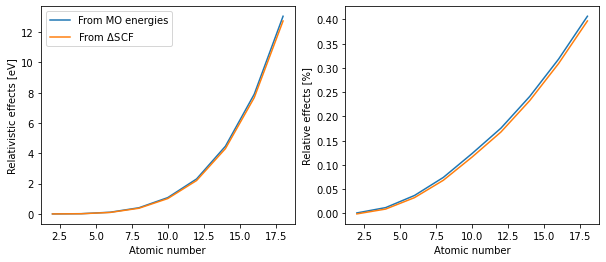

In [38]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(z,rel_mo)
plt.plot(z,rel_delta)
plt.legend(('From MO energies',r'From $\Delta$SCF'))
plt.xlabel('Atomic number')
plt.ylabel('Relativistic effects [eV]')
plt.subplot(122)
plt.plot(z,100*np.array(rel_mo)/np.array(rel_e))
plt.plot(z,100*np.array(rel_delta)/np.array(rel_e))
plt.xlabel('Atomic number')
plt.ylabel('Relativistic effects [% of total energy]')
plt.show()

#### For spectra (XAS)

In [147]:
mol = gto.Mole()
mol.atom  = water; mol.basis = 'unc-6-31G'
mol.build()

# non-relativistic
scf_nr  = scf.RHF(mol); scf_nr.kernel()
adc_nr  = adcc.cvs_adc2(scf_nr,n_singlets=5,core_orbitals=1)

# relativistic
scf_rel = scf.RHF(mol).x2c1e(); scf_rel.kernel()
adc_rel = adcc.cvs_adc2(scf_rel,n_singlets=5,core_orbitals=1)

converged SCF energy = -75.9890271783229


/home/thomas/pkg/adcc/adcc/backends/__init__.py:48: UserWarning: Could not check host program psi4 minimal version, since __version__ tag not found. Proceeding anyway.
  "".format(module)


Starting cvs-adc2 singlet Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1    10        2.7777  716ms  [20.27588296 20.31155183 20.86140432 20.92171887 20.92996834]
  2    20      0.035824  780ms  [19.72872545 19.81092766 20.31040554 20.40470691 20.49837544]
  3    30    4.1402e-05   1.1s  [19.72388013 19.80673445 20.3057139  20.39997868 20.49772007]
=== Converged ===
    Number of matrix applies:    30
    Total solver time:             2s 702ms
converged SCF energy = -76.0403950942123
Starting cvs-adc2 singlet Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1    10        2.7842  483ms  [20.29049204 20.32651304 20.87612706 20.93658562 20.9451677 ]
  2    20      0.036027  388ms  [19.74278629 19.82524258 20.32473443 20.41889866 20.51251234]
  3    30    4.1677e-05  555ms  [19.73792472 19.82102908 20.32001931 20.41414446 20.51185242]
=== Converged ===
    Number of matrix applies:    30
    Total solver time:             1s 458ms


with results:

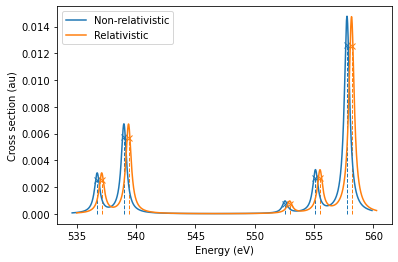

Energy shift of the first feature: 0.38 eV


In [148]:
plt.figure()
adc_nr.plot_spectrum(label='Non-relativistic')
adc_rel.plot_spectrum(label='Relativistic')
plt.legend(); plt.show()
print('Energy shift of the first feature:',
      np.around(au2ev*(adc_rel.excitation_energy[0]-adc_nr.excitation_energy[0]),2),'eV')

### Spin-orbit coupling

```{note}
Will not be able to illustrate for a while, but maybe insert short discussion.
```

## Relaxation

1. Radial distribution: Z, Z with hole, Z+1

2. Total density: formaldehyde

3. Maybe: visualization of effects for XAS and XES


```{figure} ../img/xray/relax_form.svg
---
name: relax_form
---
foo
```

```{figure} ../img/xray/relax_processes.svg
---
name: relax_processes
---
foo
```


### Including with $\Delta\textrm{SCF}$ methods

```{note}
Illustrative calculations.
```

### Including for wave function methods

```{note}
Maybe relaxation versus v2, or so.
```


### Including for DFT-based methods

```{note}
Not sure anything can really be said.
```


## Basis set considerations

The basis set requirements of X-ray spectrum calculations will depend strongly on which spectroscopy

- XPS and XES probes occupied states, and thus need a good description of those

- XAS and RIXS probes excited states, and thus need an improved description also of this region

However, in both cases the relaxation due to the creation of a core-hole need to be enabled, which yield requirements of reasonable flexibility of the core and inner valence region. This is not typically the case, as most studies deals with valence electron and thus have a minimal or close to minimal description of the core region.

A number of approaches for improving the basis sets have been developed:

1. Augment the Dunning basis sets with core-polarizing functions, e.g. cc-pV*n*Z $\rightarrow$ cc-pCV*n*Z

2. Adding extra flexibility by performing full or partial decontraction, e.g.
    1. u6-311++G** is 6-311++G** with decontracted 1s function of the probed element
    2. un-6-311++G** is a fully decontracted 6-311++G** basis set

3. Use basis functions from the next element, is inspired by the equvalent core/Z+1 approximation

Here we focus on the basis set effects for calculations of the IP of water, and we encourage the interested reader to do the same excercise for XES, as well as for XAS (where the augmentation of diffuse functions also need to be considered).

In [ ]:
u6311gss  = {'O': gto.basis.parse('''
O    S
   8588.500                  1.000000 
O    S
   1297.230                  1.000000 
O    S
    299.2960                 1.000000 
O    S
     87.37710                1.000000 
O    S
     25.67890                1.000000 
O    S
      3.740040               1.000000 
O    SP
     42.11750                0.113889               0.0365114
      9.628370               0.920811               0.237153
      2.853320              -0.00327447             0.819702
O    SP
      0.905661               1.000000               1.000000
O    SP
      0.255611               1.000000               1.000000
O    D
      1.292                  1.000000
'''), 'H': '6-311G**'}
un6311gss = {'O': gto.basis.parse('''
O    S
   8588.500                  1.000000 
O    S
   1297.230                  1.000000 
O    S
    299.2960                 1.000000 
O    S
     87.37710                1.000000 
O    S
     25.67890                1.000000 
O    S
      3.740040               1.000000 
O    SP
     42.11750                1.000000               1.000000
O    SP
      9.628370               1.000000               1.000000
O    SP
      2.853320               1.000000               1.000000
O    SP
      0.905661               1.000000               1.000000
O    SP
      0.255611               1.000000               1.000000
O    D
      1.292                  1.000000
'''), 'H': '6-311G**'}
z6311gss  = {'O': gto.basis.parse('''
O    S
   8588.500                  0.00189515
   1297.230                  0.0143859
    299.2960                 0.0707320
     87.37710                0.2400010
     25.67890                0.5947970
      3.740040               0.2808020
O    SP
     42.11750                0.113889               0.0365114
      9.628370               0.920811               0.237153
      2.853320              -0.00327447             0.819702
O    SP
      0.905661               1.000000               1.000000
O    SP
      0.255611               1.000000               1.000000
O    D
      1.292                  1.000000
O    S
  11427.10                   0.00180093
   1722.350                  0.0137419
    395.7460                 0.0681334
    115.1390                 0.2333250
     33.60260                0.5890860
      4.919010               0.2995050
O    SP
     55.44410                0.114536               0.0354609
     12.63230                0.920512               0.237451
      3.717560              -0.00337804             0.820458
O    SP
      1.165450               1.000000               1.000000
O    SP
      0.321892               1.000000               1.000000
O    D
      1.750                  1.000000
'''), 'H': '6-311G**'}

Exotic version of basis sets found above

```python
basis_sets = ['6-311G**',u6311gss,un6311gss,z6311gss, 'cc-pVDZ', 'cc-pCVDZ', 'cc-pVTZ', 'cc-pCVTZ','cc-pVQZ', 'cc-pCVQZ']
ip_hf, ip_mp2, ip_ccsd, ip_b3lyp, n_bas = [],[],[],[],[]
for basis in basis_sets:
    mol = gto.Mole(); mol.atom  = water; mol.basis = basis
    mol.build()
    scfres = scf.UHF(mol); scfres.kernel()
    mo0 = copy.deepcopy(scfres.mo_coeff); occ0 = copy.deepcopy(scfres.mo_occ); occ0[0][0] = 0.0
    scfion = scf.UHF(mol); scf.addons.mom_occ(scfion, mo0, occ0); scfion.kernel()
    ip_hf.append(au2ev*(scfion.energy_tot() - scfres.energy_tot()))
    ccsd_res = cc.UCCSD(scfres).run(); ccsd_ion = cc.UCCSD(scfion).run(max_cycle=500)
    ip_ccsd.append(au2ev*(ccsd_ion.e_tot - ccsd_res.e_tot))
    ip_mp2.append(au2ev*(ccsd_ion.e_hf+ccsd_ion.emp2-(ccsd_res.e_hf+ccsd_res.emp2)))
    scfres = scf.UKS(mol); scfres.xc = 'b3lyp'; scfres.kernel()
    mo0 = copy.deepcopy(scfres.mo_coeff); occ0 = copy.deepcopy(scfres.mo_occ); occ0[0][0] = 0.0
    scfion = scf.UKS(mol); scf.addons.mom_occ(scfion, mo0, occ0); scfion.xc = 'b3lyp'; scfion.kernel()
    ip_b3lyp.append(au2ev*(scfion.energy_tot() - scfres.energy_tot()))
    n_bas.append(len(scfres.mo_occ[0]))
    
plt.figure(figsize=(10,5))
basis_set_labels = ['6-311G**','u6-311G**','un6-311G**','6-311G** (Z+1)', 'cc-pVDZ', 'cc-pCVDZ', 'cc-pVTZ', 'cc-pCVTZ','cc-pVQZ', 'cc-pCVQZ']
plt.plot(n_bas,ip_hf,'r*'); plt.plot(n_bas,ip_mp2,'bv')
plt.plot(n_bas,ip_ccsd,'d',color='orange'); plt.plot(n_bas,ip_b3lyp,'go')
plt.plot([min(n_bas)-5,max(n_bas)+5],[539.9,539.9],'k:')
plt.plot([min(n_bas)-5,max(n_bas)+5],[539.9-0.3,539.9-0.3],'k--')
plt.xlim((min(n_bas)-5,max(n_bas)+5))
plt.ylabel('Ionization potential [eV]')
plt.legend(('HF','MP2','CCSD','B3LYP','Expt','Expt - 0.3 eV'))
plt.xticks(n_bas,basis_set_labels,rotation=70,fontsize=10)
plt.tight_layout(); plt.savefig('basis_xps.svg')
plt.show()
```

The execution of which yields



```{figure} ../img/xray/basis_xps.svg
---
name: basis_xps
---
foo
```

On the y-axis we see the basis set labels, with order and position determined by the number of basis functions.

We see that...

## General recommendations

What follows are some general suggestions for practical calculations, which is naturally an  incomplete list with some of the Authors biases unavoidably being included. Consider this as a hopefully helpful guide,but not more than that.

### *Precision* versus *accuracy*

Because of the many difficulties in modeling X-ray spectra (relativity, relaxation, self-interaction, high energies...), even very sophisticated (and expensive!) methods often struggles in getting good *absolute* energies. These cannot be expected to be as good as for valence excitations. I argue that the focus should be more on properly reproducing *relative* rather than *absolute* trends, which can be formulated as focusing on  precision over accuracy, where

- Accuracy correspond to the deviation from the absolute energies and intensities, or the systematic error.

- Precision focus on the reproducability of relative energies and intensities, or (relative) error distribution.

We have [shown] that good accuracy does not nedessarily correspond to as good precision, and our philosophy is that obtaining good trends and relative errors is sufficient for prectical studies (provided we have some idea of the source of the absolute error, and good reasons to think that it will noit differ between the systems). Absolute errors can then be corrected by a mere absolute shift in energy.


### Electronic stucture method

Single determinant wave function methods can include relaxation by the use of (at least) doubly excited configurations. These methods tend to yield relatively consistent description of the processes, and are thus recommended to be used for (at least) controls. Due to the cost, however, they are often unviable for larger systems. Families and recommendations include:

- Coupled cluster

    - CCSD has been noted to yield consistent results for XAS and XES, and 
    
    - CC3 has been seen to improve the XAS results, and can be used in a multilayer manner
    
    - If computational cost is a concern, CC2 has been seen to work quite well
    
- Algebraic-diagrammatic construction scheme

    - ADC(2) yields superiour results for XES, and works quite well for the valence states in XAS (the shift to higher-lying features are likely to be compressed, however). 
    
    - ADC(2)-x has been noted to yield best results for XAS, despite being quite unsuitable for valence excitations. This has been identified as a result of balancing effects for capturing the strong relaxation effects in XAS.
    
    - ADC(3/2) has been noted to yield a poorer description of both XAS and XES, despite its higher level of theory and higher computational cost. *However*, for X-ray emission spectra of systems in an environment, double-excitations may interfer with the emission states for ADC(2) and ADC(2)-x. ADC(3/2) will then be most suitable.

With TDDFT (or CPP-DFT), the exchange-correlation functional depends on the edge and the element, as the exact balance of relaxation and self-interaction varies significantly. Good absolute energies are often obtained by balancing the error of the lack of relaxation versus the self-interaction, which is achieved by changing the amount of HF exchange. Focusing on the second row we have seen that:

- CAM-B3LYP (potentially using 100% asymptotic HF) has been seen to yield good relative energies (precision), but poor absolute energies (accuracy). Intensitites are also quite good, so a mere absolute shift often yield good agreement with experiment.

- SRC2-R1 is from a family of short-range correlated functionals, formulated for good absolute XAS energies. 

If static correlation becomes substantial, methods based on a single Slater determinant reference will become unsuitable. ADC will be worst off, on account of the MP reference, with CC being slightly more successful for these cases. Spin-flip ADC and CC can improve the situation for certain few-reference systems. TDDFT will be a bit more capable of considering these cases. However, systems with strong static correlation should be studied carefully, and multi-reference methods are likely the safest way forward. Need to know which active space to choose, etc.

Transition-metal complexes can have strong static correlation, which would aim to multi-reference methods. For some cases ADC or CC works quite well - just check it. Furthermore, TM complexes can need (spin-orbit) relativistic effects, and quadruple-allowed transition can become substantial.

Other methods, such as... can also be used.


### Basis set selection


As previously [discussed], standard basis set often include a minimal, or close to minimal, basis set for the core region, as computational chemistry commonly focus on the valence electrons. For core spectroscopies this region thus often need to be augmented by some method, which may include decontracting core basis functions, including core-polarizing functions, augmenting the basis set with basis functions for $Z++1$ or $Z+1/2$, or some other method. It can be noted, however, that this augmentation is not necissary for high precision, provided that the lacking description of the core region yield similar errors for different states and/or atomic sites.

Nevertheless, my general recommendation would be to use cc-pCVTZ for the atoms probed, and cc-pVTZ for the remaining atoms. Dunning basis set 6-311G** has also been seen to perform quite well, and the core basis functions can here be decontracted for u6-311G**. Hydrogen atoms and atoms away from the probed core orbitals can likely be dropped to a double-$\zeta$ desciption. A double-$\zeta$ (*e.g.* cc-pVDZ/cc-pCVDZ or 6-31G*/u6-31G*) can be used with some care for larger systems and more approximate methods.

- **XPS:** If some $\Delta\textrm{SCF}$ method is used, a flexible description of the core and valence region 

- **XAS:** Probes unoccupied states, and thus need to be augmented to describe this region. For the valence-type final states it is likely to be sufficient to add more diffuse functions, *i.e.* aug-cc-pCVTZ or 6-311++G**. Adding the Dunning diffuse functions are likely not necessary for hydrogen. Furthermore, if Rydberg/mixed-Rydberg states are to be studied, augmentation with additional diffuse function can be necessary.

- **XES:** Shares requirements with XPS.

- **RIXS:** Probes both the occupied and unoccupied states, and thus need a good (and balanced) description of both. The recommendations for XAS and XES can thus be considered to transfer over to this spectroscopy.

Note that for heavier atoms the core region contains several shells. As the core-polarizing functions are formulated to capture core-valence correlation, it will then more efficiently augment the outer, rather than the inner, core region. AS such, additional (inner) core basis functions would be needed for approaching the BSL of these atoms. Still, with the discussion of precision above, the weak interaction between the inner core and valence region means that core-polarization may anyway just yield an absolute error correction.


### Relativistic effects

If the *K*-edge is considered, scalar relativistic effects are only needed, as can be done with X2C or Douglas-Kroll-Hess. Alternatively, it is often sufficient to just add an absolute scalar shift in energy for a non-relativistic calculation (such a shift is likely needed anyway, as absolute energies are notoriously hard to reproduce). This absolute shift can be estimated by simple MO energy calculations, as shown [above].

If *l>0* is to be considered, spin-orbit splitting effects will potentially be substantial. Including this can be done with...

## Notes

```{margin} Margin
This is how it would look.
```

```{note}
**Not included (yet)**
- SO-coupling
- beyond electrinc-dipole approximation
- multireference methods
```